# Tumors inference with PyMC3.

##### Keywords: beta-binomial, hierarchical, pymc3, posterior predictive

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time

# Tumors in rats

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using Gibbs sampling in a previous lab. Remember that the goal is to estimate $\theta$, the probability of developing a tumor in a population of female rats that have not received treatement. Data of a particular experiment shows that 4 out of 14 rats develop the tumor. But we also have historical literature data for other 70 experiments, which give estimates $\theta_i$. 

For convenience, we adopt a prior for $\theta_i$ from the conjugate *Beta* family: $\theta_i \sim Beta(\alpha, \beta)$. If we had an expert telling us the values for $\alpha$ and $\beta$, we could just calculate the posterior using the conjugate rules. But we do not usually have that. We have, instead, the historical data, that we can use to perform inference for $\theta_i$, the tumor probability in the current experiment

It is natural the model the number $y_i$ of tumors for *each* experiment performed on a total of $n_i$ rats as a binomial:

$$
p(y_i \vert \theta_i; n_i) =  Binom(n_i, y_i, \theta_i)
$$

We can now write a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$, assuming partial pooling (i.e., hierarchical Bayes), where the $\theta_i$ is assumed to be different for each experiment, but all drawn from the same *Beta* distribution with parameteres $\alpha$ and $\beta$:

$$p( \theta_i, \alpha, \beta  \vert  y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i  \vert  \alpha, \beta) \, p(y_i  \vert  \theta_i, n_i,\alpha, \beta)$$
or for the whole dataset:
$$ p( \Theta, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

So we only need to figure out the prior for the hyperparameters: $p(\alpha,\beta)$. We have shown that it is convenient to use uniform priors on the alernative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}$$
$$\nu = (\alpha+\beta)^{-1/2}$$

which yiels a prior for $\alpha$ and $\beta$ of the form:

$$p(\alpha,\beta) \sim (\alpha+\beta)^{-5/2}$$

Let us firs load the data:

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

And now let us create two arrays, one for the observed tumors and one for the total number of rats in each of the 70 experiments.

In [3]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
print(tumory, tumorn)
print(np.shape(tumory))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  3  2  2
  2  2  2  2  2  2  2  1  5  2  5  2  7  7  3  3  2  9 10  4  4  4  4  4  4
  4 10  4  4  4  5 11 12  5  5  6  5  6  6  6  6 16 15 15  9] [20 20 20 20 20 20 20 19 19 19 19 18 18 17 20 20 20 20 19 19 18 18 27 25 24
 23 20 20 20 20 20 20 10 49 19 46 17 49 47 20 20 13 48 50 20 20 20 20 20 20
 20 48 19 19 19 22 46 49 20 20 23 19 22 20 20 20 52 46 47 24]
(70,)


Just to have some intuition let us get the naive probabilities ($y_i/n_i$) of developing a tumor for each of the 70 experiments, and let's print the mean and the standard deviation:

In [4]:
tumor_rat = [float(e[0])/float(e[1]) for e in zip(tumory, tumorn)]
#print (tumor_rat)
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
print(tmean, tvar)

0.13600653889 0.0105576406236


We now write the model in PyMC3. PyMC3 will by default use the NUTS algorithm, unless told otherwise. Once the step method has been chosen, PyMC3 will also optimize for the parameters of the method (step sizes, proposal distributions, scaling, starting values for the parameters, etc), but we can also manually set those. Here we use both NUTS and Metropolis to perform the sampling. First let us load the relevant probability distributions

### Setting up the PyMC3 model

Now let us set up the model. Note the simplification with respect to the Gibbs sampler we have used earlier. Because PyMC3 takes care of refining the parameters of the selected step method, or uses gradient-based methods for the sampling, it does not require us to specify the conditionals distributions for $\alpha$ and $\beta$. We only need to specify the priors for $\mu$ and $\nu$, and then write expressions for $\alpha$ and $\beta$ as a function of $\mu$ and $\nu$. Note that we use the ```pm.Deterministic``` function to define $\alpha$ and $\beta$ and give them proper names. Without a name, these variables will not be included in the trace.

In [95]:
# pymc3
from pymc3 import Uniform, Normal, HalfNormal, HalfCauchy, Binomial, Beta, sample, Model # Import relevant distributions

N = tumorn.shape[0]

with Model() as tumor_model:

    # Uniform priors on the mean and variance of the Beta distributions
    mu = Uniform("mu",0.00001,1.)
    nu = Uniform("nu",0.00001,1.)
    #nu = HalfCauchy("nu", beta = 1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha = pm.Deterministic('alpha', mu/(nu*nu))
    beta = pm.Deterministic('beta', (1.-mu)/(nu*nu))
    
    # Priors for each theta
    thetas = Beta('theta', alpha, beta, shape=N)
    
    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n=tumorn, p=thetas, observed=tumory)

In [96]:
from pymc3 import find_MAP

with tumor_model:
    # instantiate sampler
    step = pm.Metropolis()
    
    # draw 2000 posterior samples
    tumor_trace = pm.sample(200000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [nu]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 401000/401000 [04:26<00:00, 1505.99draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [97]:
mtrace = tumor_trace[100000::25]
pm.summary(mtrace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,5.000669e-01,6.287878e-05,0.000006,4.999661e-01,5.001860e-01,3.234569,1.360175
nu,3.611176e-04,8.753924e-05,0.000008,2.014466e-04,5.066631e-04,1.942442,1.652039
alpha,4.727586e+06,2.801670e+06,261826.826631,1.566256e+06,1.042954e+07,2.390785,1.526307
beta,4.726268e+06,2.800994e+06,261764.660399,1.566473e+06,1.042653e+07,2.392376,1.525924
theta__0,5.000391e-01,1.800322e-04,0.000018,4.997121e-01,5.003853e-01,9.831093,0.999910
theta__1,5.001020e-01,1.329097e-04,0.000013,4.998569e-01,5.003674e-01,26.436879,1.099340
theta__2,5.001533e-01,1.659936e-04,0.000016,4.998351e-01,5.004404e-01,12.091202,1.007664
theta__3,4.999507e-01,2.331874e-04,0.000023,4.994840e-01,5.003726e-01,3.010059,1.402556
theta__4,5.002441e-01,1.948635e-04,0.000019,4.999769e-01,5.006585e-01,7.904370,1.194238
theta__5,5.000091e-01,2.041813e-04,0.000020,4.996871e-01,5.003607e-01,3.004450,1.384933


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1086012e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x184a1e940>]], dtype=object)

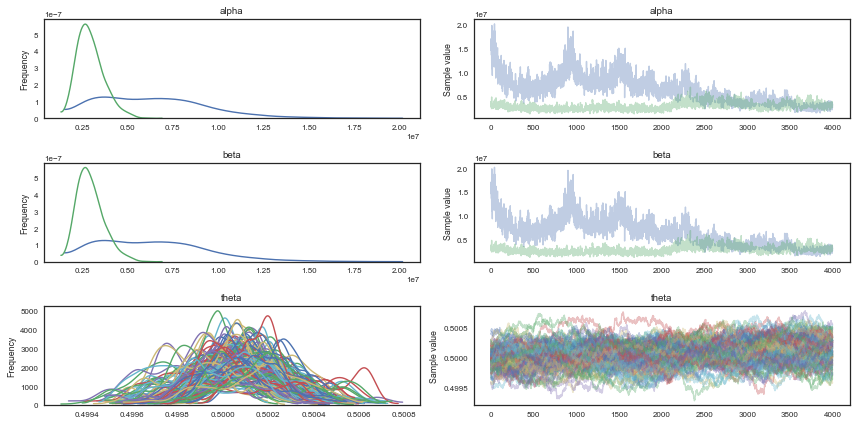

In [98]:
from pymc3 import traceplot

traceplot(mtrace, varnames=['alpha','beta','theta'])

I have used the first half of the original samples for burnin. Note that we need many iterations, and a significant amount of thinning in order to make it converge and have uncorrelated samples. We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (sns.kdeplot in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. Further down we also look at the autocorrelation plots for $\alpha$, $\beta$, and $\theta_1$.

#### Autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11355b3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x181a0c9b0>]], dtype=object)

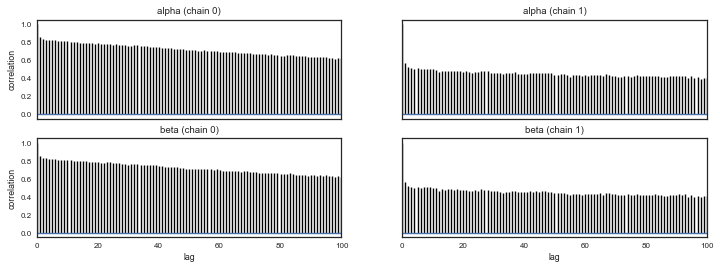

In [99]:
pm.autocorrplot(mtrace,varnames=['alpha','beta'])

#### NUTS

Let's try with NUTS now:

In [100]:
with tumor_model:
    tumor_trace = pm.sample(40000)#, step, start=mu)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, nu, mu]
Sampling 2 chains: 100%|██████████| 81000/81000 [03:33<00:00, 379.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


Discussion on warmup and adaptation: https://andrewgelman.com/2017/12/15/burn-vs-warm-iterative-simulation-algorithms/

In [102]:
tt = tumor_trace[5000::]
pm.summary(tt)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.142671,0.013482,0.000049,0.116257,0.169103,59109.621269,0.999987
nu,0.256804,0.043600,0.000395,0.173587,0.343456,14076.577169,1.000003
alpha,2.356234,0.885711,0.009062,1.009642,4.090366,11920.240119,1.000041
beta,14.232511,5.335247,0.053187,5.901158,24.734979,12760.797477,1.000032
theta__0,0.062545,0.041190,0.000155,0.001426,0.142216,57114.307338,0.999986
theta__1,0.062545,0.041059,0.000168,0.000175,0.140762,61814.151395,0.999987
theta__2,0.062449,0.041228,0.000180,0.000782,0.141716,58898.117106,0.999986
theta__3,0.062585,0.041198,0.000179,0.000580,0.141435,58406.712770,0.999987
theta__4,0.062153,0.040964,0.000176,0.000585,0.141045,60698.101006,1.000010
theta__5,0.062497,0.041606,0.000164,0.000292,0.142410,63046.941193,0.999993


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18c574d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1965b6eb8>]], dtype=object)

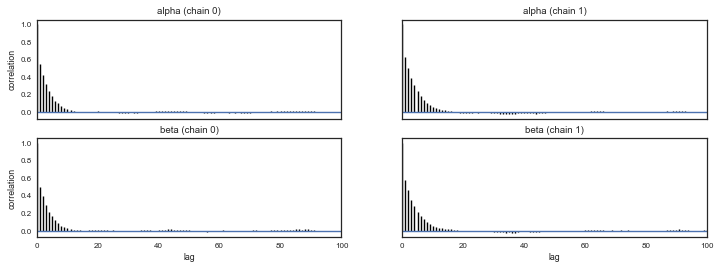

In [103]:
pm.autocorrplot(tt, varnames=['alpha','beta'])

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


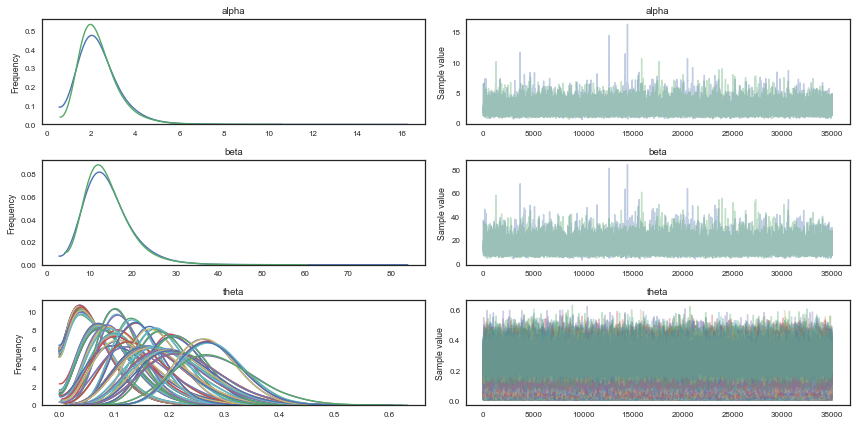

In [104]:
from pymc3 import traceplot

#traceplot(bioassay_trace[500:], varnames=['alpha'])
traceplot(tt, varnames=['alpha','beta','theta']);

Text(0, 0.5, '$\\log(\\alpha+\\beta)$')

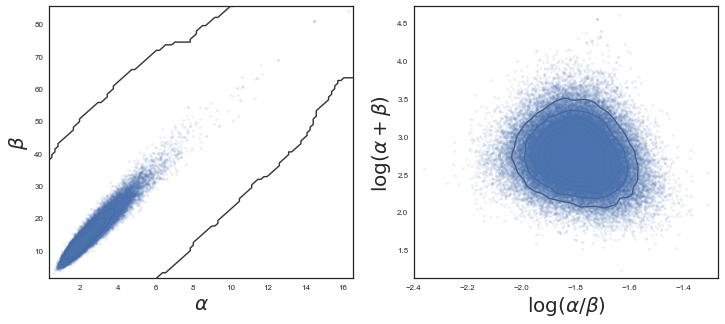

In [105]:
fig = plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(tt['alpha'], tt['beta'],'.', alpha=0.1)
sns.kdeplot(tt['alpha'], tt['beta'])
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)
plt.subplot(1,2,2)
plt.plot(np.log(tt['alpha']/tt['beta']), np.log(tt['alpha']+tt['beta']),'.', alpha=0.1)
sns.kdeplot(np.log(tt['alpha']/tt['beta']), np.log(tt['alpha']+tt['beta']))
plt.xlabel(r"$\log(\alpha/\beta)$",size=20)
plt.ylabel(r"$\log(\alpha+\beta)$",size=20)

Note the advantage of using gradients for sampling (stay tuned for Hamiltonian Monte Carlo). We need way less samples to converge to a similar result as with Metropolis, and autocorrelation plots look beter. Let us move to checking convergence for the NUTS sampler, using the Geweke diagnostic. It is important to check that both $\alpha$ and $\beta$ has converged.

In [106]:
tt.varnames

['mu_interval__',
 'nu_interval__',
 'theta_logodds__',
 'mu',
 'nu',
 'alpha',
 'beta',
 'theta']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x17fce90f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1086839b0>], dtype=object)

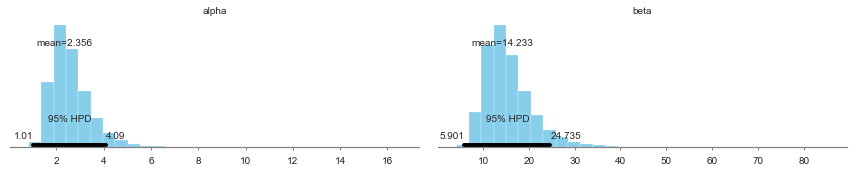

In [107]:
pm.plot_posterior(tt, varnames=['alpha', 'beta'])

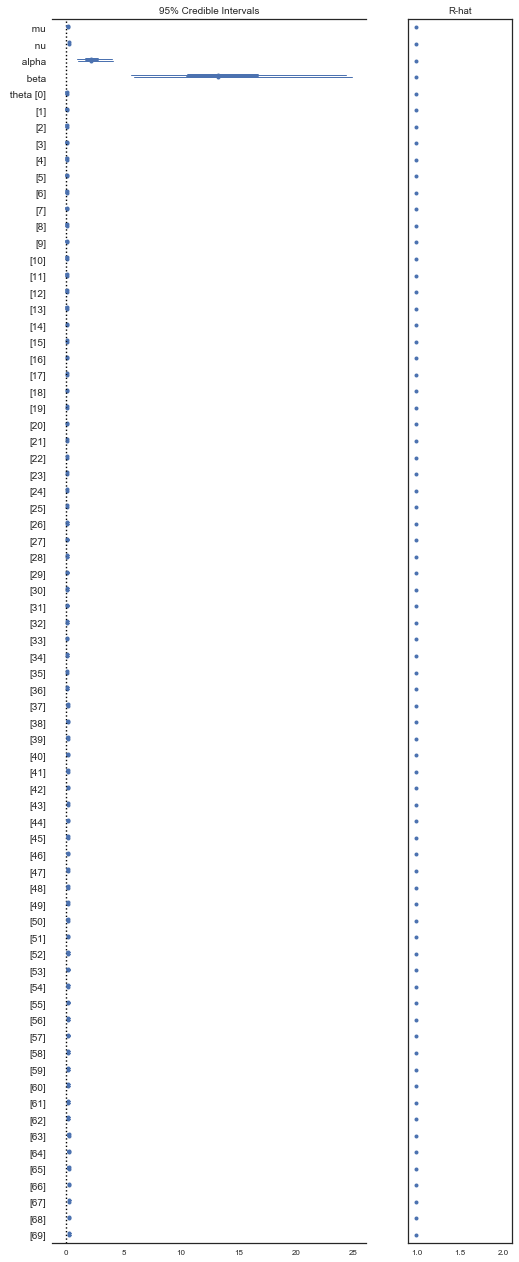

In [108]:
plt.figure(figsize=(8, 20))
pm.forestplot(tt, );

In [109]:
from pymc3 import geweke
z1 = geweke(tt, intervals=15)[0]
z2 = geweke(tt, intervals=15)[1]

In [110]:
tt.get_values('alpha', chains=0).shape

(35000,)

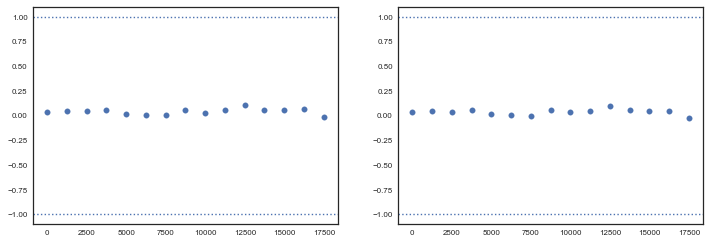

In [111]:
fig = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(*z1['alpha'].T)
plt.axhline(-1, 0, 1, linestyle='dotted')
plt.axhline(1, 0, 1, linestyle='dotted')


plt.subplot(1,2,2)
plt.scatter(*z1['beta'].T)
plt.axhline(-1, 0, 1, linestyle='dotted')
plt.axhline(1, 0, 1, linestyle='dotted')


In [112]:
from pymc3 import sample_ppc
with tumor_model:
    tumor_sim = sample_ppc(tt, samples=500)

100%|██████████| 500/500 [00:03<00:00, 138.18it/s]


In [113]:
tumor_sim['obs_deaths'].T[59].shape

(500,)

Let's plot a few of the posterior predictives and the observed data:

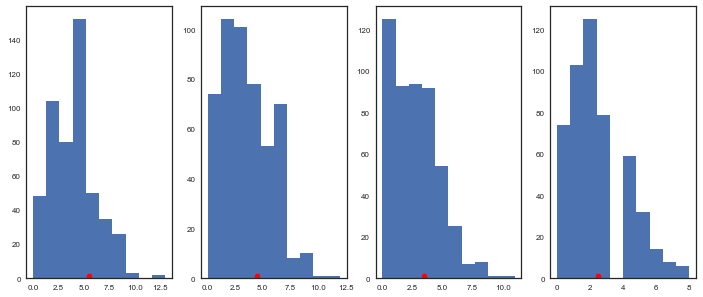

In [114]:
fig = plt.subplots(1, 4, figsize=(12, 5))
plt.subplot(1,4,1)
plt.hist(tumor_sim['obs_deaths'].T[59])
plt.plot(tumory[59]+0.5, 1, 'ro')
plt.subplot(1,4,2)
plt.hist(tumor_sim['obs_deaths'].T[49])
plt.plot(tumory[49]+0.5, 1, 'ro')
plt.subplot(1,4,3)
plt.hist(tumor_sim['obs_deaths'].T[39])
plt.plot(tumory[39]+0.5, 1, 'ro')
plt.subplot(1,4,4)
plt.hist(tumor_sim['obs_deaths'].T[29])
plt.plot(tumory[29]+0.5, 1, 'ro')

A more meaningful plot is the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. With ```df_summary``` we can get the summary with the means and the percentiles directly into a pandas dataframe:

In [115]:
from pymc3 import summary

df_sum = summary(tt, varnames=['theta'])
df_sum.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.062545,0.041190,0.000155,0.001426,0.142216,57114.307338,0.999986
theta__1,0.062545,0.041059,0.000168,0.000175,0.140762,61814.151395,0.999987
theta__2,0.062449,0.041228,0.000180,0.000782,0.141716,58898.117106,0.999986
theta__3,0.062585,0.041198,0.000179,0.000580,0.141435,58406.712770,0.999987
theta__4,0.062153,0.040964,0.000176,0.000585,0.141045,60698.101006,1.000010


In [116]:
medianthetas = df_sum['mean'].values
lowerthetas = df_sum['hpd_2.5'].values
upperthetas = df_sum['hpd_97.5'].values

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

Our naive, non-Bayesian estimate of the probabilities would have been just the ratio of rats with tumor to total number of observed rats in each experiment:

In [117]:
ratios=tumory.astype(float)/tumorn

Now let us compare those naive estimates to our posterior estimates:

(-0.1, 0.5)

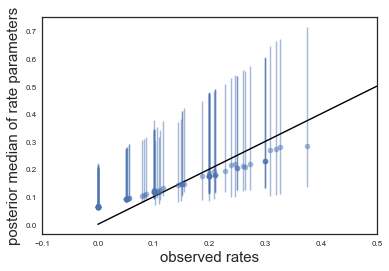

In [118]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates",size=15)
plt.ylabel("posterior median of rate parameters",size=15)

plt.xlim(-0.1,0.5)

Also see this problem in the pymc3 examples: https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html